# Resultados Decision Tree

# Imports

In [1]:
import pandas as pd 
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
from funcoes_module import rms, pk_pk, kurtosis, crest_factor, skewness, shape_factor, std_value, min_value, max_value, mean_value
from funcoes_module import extract_info_from_filename, extract_and_format_dataframe, format_time, features_extract, features_timeframe,format_dataframe_basona ,extract_datasets_and_process_features,read_1file_datasets , combine_features_datasets 
from funcoes_module import plot_df,plot_df_features, compare_df_plots #,plot_health_non_health_features
from descricoes_SE import descricao_falha

In [3]:
redundant_ft_drop_list = ['gearbox_vibration_x.rms','gearbox_vibration_z.kurtosis','gearbox_vibration_z.rms','gearbox_vibration_x.crest_factor','gearbox_vibration_x.min','gearbox_vibration_x.pk_pk','Input Torque.mean']

## Funções Formatação

In [4]:
#### #### Funções Formatação #### ####
def normalize_data(dataframe):
    scaler = MinMaxScaler() 
    # Selecting numerical columns in the DataFrame
    numerical_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns
    #normalized_df =dataframe.copy()
    # Fitting the scaler and transforming the data
    df2 = dataframe.copy()
    df2[numerical_cols] = scaler.fit_transform(df2[numerical_cols])
    return df2

def fault_to_binary(dataframe):
    df_features = dataframe.copy()
    if not ((df_features['Fault'] == 0) | (df_features['Fault'] == 1)).all(): #condição para não dar ruim se aplicar 2x a função
        df_features['Fault'] = df_features['Fault'].apply(lambda x: 0 if x == 'health' else 1)
    #df_features['Fault'].value_counts()
    return df_features

def top_features_list(df_features, num_features):
    # Select numeric types from the DataFrame
    df_features_num = df_features.select_dtypes(include=['float64', 'int64'])
    
    # Compute the absolute correlation with 'Fault'
    top_features = abs(df_features_num.corr()['Fault'])
    
    # Drop the 'Fault' column from the series to avoid self-correlation
    top_features = top_features.drop('Fault', axis=0)
    
    # Get the 'num_features' largest values
    largest_features = top_features.nlargest(num_features)
    
    # Return the index of the largest features as a list
    features_chosen = largest_features.index.tolist()
    return features_chosen

def filter_top_features_df(df_features,top_features):    
    filtered_columns = top_features + ['Fault','Torque']#,'Degree']
    df_features = df_features[filtered_columns]
    return df_features

def format_dataframe_features(df_features_org,number_of_features):

    normalized_dataframe = normalize_data(df_features_org)
    binary_fault_dataframe = fault_to_binary(normalized_dataframe)

    top_ft_list = top_features_list(binary_fault_dataframe,number_of_features)

    df_top_features = filter_top_features_df(binary_fault_dataframe,top_ft_list)
    return df_top_features,binary_fault_dataframe

# Início
- df_treino_ciclo1
- df_treino_ciclo2
- df_teste_ciclo1
- df_teste_ciclo2
  
Importando dataset treino

In [5]:
# importando e criando basone treino
df_features_org = combine_features_datasets("todos","inicial",0.1)
########df_features_org = df_features_org[df_features_org['Torque']=='20Nm']

#df_features_org2 = df_features_org.drop(columns=redundant_ft_drop_list) #dropando features redundantes
normalized_dataframe = normalize_data(df_features_org)

df_treino_ciclo2 = normalized_dataframe
df_treino_ciclo1 = fault_to_binary(normalized_dataframe) #transformando variável alvo em binário (encoding)


# Importando e criando basona teste
df_features_org_t = combine_features_datasets("todos","final",0.1) #treino,teste,todos ; inicial,final ; timeframe
#######df_features_org_t = df_features_org_t[df_features_org_t['Torque']=='20Nm']
#df_features_org_t2 = df_features_org_t.drop(columns=redundant_ft_drop_list)
normalized_dataframe_t = normalize_data(df_features_org_t)

df_teste_ciclo1 = fault_to_binary(normalized_dataframe_t)
df_teste_ciclo2 = normalized_dataframe_t


Columns [col] not found in [filename]
number of files geral = 23
combined files geral: ['gear_pitting_H_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_H_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_M_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_M_to

# Organizando as variáveis 
## Organizando as variáveisCiclo1 
### Dividir Conjunto em treino e teste
- df_treino_ciclo1
- df_teste_ciclo1
  
importante usar o meu encoder próprio pq ele classifica do jeito q eu quero 1 = tudo menos health, 0 = health

Separando entre treino e teste

In [6]:
categorias_list = ['Categoria','Degree','Rotação']

dataset_treino_c1 = df_treino_ciclo1.drop(columns=categorias_list)   # 60%
dataset_teste_c1 = df_teste_ciclo1.drop(columns=categorias_list) #40%

Separando X e y

In [7]:
#treino
X_train_c1 = dataset_treino_c1.drop(columns='Fault')#.iloc[:,-2:] filtrar n features
y_train_c1 = dataset_treino_c1.pop('Fault')

#teste
X_test_c1 = dataset_teste_c1.drop(columns='Fault')
y_test_c1 = dataset_teste_c1.pop('Fault')


In [8]:
print(f' Treino: x ={X_train_c1.shape} ; y = {y_train_c1.shape}')
print(f' Teste: x ={X_test_c1.shape} ; y = {y_test_c1.shape}')

 Treino: x =(2160, 41) ; y = (2160,)
 Teste: x =(2133, 41) ; y = (2133,)


Tratando a coluna categórica 'Torque' com label encoding

In [9]:
from sklearn.preprocessing import LabelEncoder
# Assuming 'Torque' column is in both X_train, X_val, and X_test
le = LabelEncoder()

# Fit and transform on the training data
X_train_c1['Torque'] = le.fit_transform(X_train_c1['Torque'])
X_test_c1['Torque'] = le.transform(X_test_c1['Torque'])

### Criando variáveis de treino e teste

In [10]:
categorias_list = ['Categoria','Degree','Rotação']

dataset_treino_c2 = df_treino_ciclo2.drop(columns=categorias_list)   # 60%
dataset_teste_c2 = df_teste_ciclo2.drop(columns=categorias_list) #40%

In [11]:
#treino
X_train_c2 = dataset_treino_c2.drop(columns='Fault')#.iloc[:,-2:] filtrar n features
y_train_c2x = dataset_treino_c2.pop('Fault')

#teste
X_test_c2 = dataset_teste_c2.drop(columns='Fault')
y_test_c2x = dataset_teste_c2.pop('Fault')

In [12]:
print(f' Treino: x ={X_train_c2.shape} ; y = {y_train_c2x.shape}')
print(f' Teste: x ={X_test_c2.shape} ; y = {y_test_c2x.shape}')

 Treino: x =(2160, 41) ; y = (2160,)
 Teste: x =(2133, 41) ; y = (2133,)


Label Encoders
- torque
- target (y)

In [13]:
from sklearn.preprocessing import LabelEncoder
# Assuming 'Torque' column is in both X_train, X_val, and X_test
le = LabelEncoder()

# Fit and transform on the training data
X_train_c2['Torque'] = le.fit_transform(X_train_c2['Torque'])
X_test_c2['Torque'] = le.transform(X_test_c2['Torque'])

aplicando encoder na target variable (opcional aparentemente)

In [14]:

# # Initialize label encoder for target variable
le_y = LabelEncoder()

# # Fit and transform the target variable
y_train_c2 = le_y.fit_transform(y_train_c2x.values)
y_test_c2 = le_y.transform(y_test_c2x.values)

### Resultado:
Criação das variáveis:
- X_train_c1
- X_train_c2
- y_train_c1
- y_train_c2
-
- X_teste_c1
- X_teste_c2
- y_teste_c1
- y_teste_c2

# Execução dos modelos 

In [15]:
#from sklearn.dt import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Testando númerode features

# DT

## Ciclo 2

Avaliando número de features

n= 1 score: 0.6955056242435859
n= 2 score: 0.7978392408357132
n= 3 score: 0.8568273723422487
n= 4 score: 0.8356884020074752
n= 5 score: 0.8457930790513514
n= 6 score: 0.8896684994941509
n= 7 score: 0.8650827378951861
n= 8 score: 0.8987041509609517
n= 9 score: 0.8915567798854069
n= 10 score: 0.9043426206239978
n= 11 score: 0.8900499399382708
n= 12 score: 0.8898077782772961
n= 13 score: 0.8644857768860411
n= 14 score: 0.8695958101166646
n= 15 score: 0.8700572574919655
n= 16 score: 0.8867024488699474
n= 17 score: 0.8712595947297442
n= 18 score: 0.8613235188532872
n= 19 score: 0.8832389216058821
n= 20 score: 0.858905420544615
n= 21 score: 0.8741870818890409
n= 22 score: 0.8686121272363266
n= 23 score: 0.8722359448404856
n= 24 score: 0.878152537211568
n= 25 score: 0.8592253166634634
n= 26 score: 0.8646306784222034
n= 27 score: 0.8646437860857898
n= 28 score: 0.8707974194177828
n= 29 score: 0.8629008092022842
n= 30 score: 0.8642113590287659
n= 31 score: 0.8700520738010079
n= 32 score: 0.8711

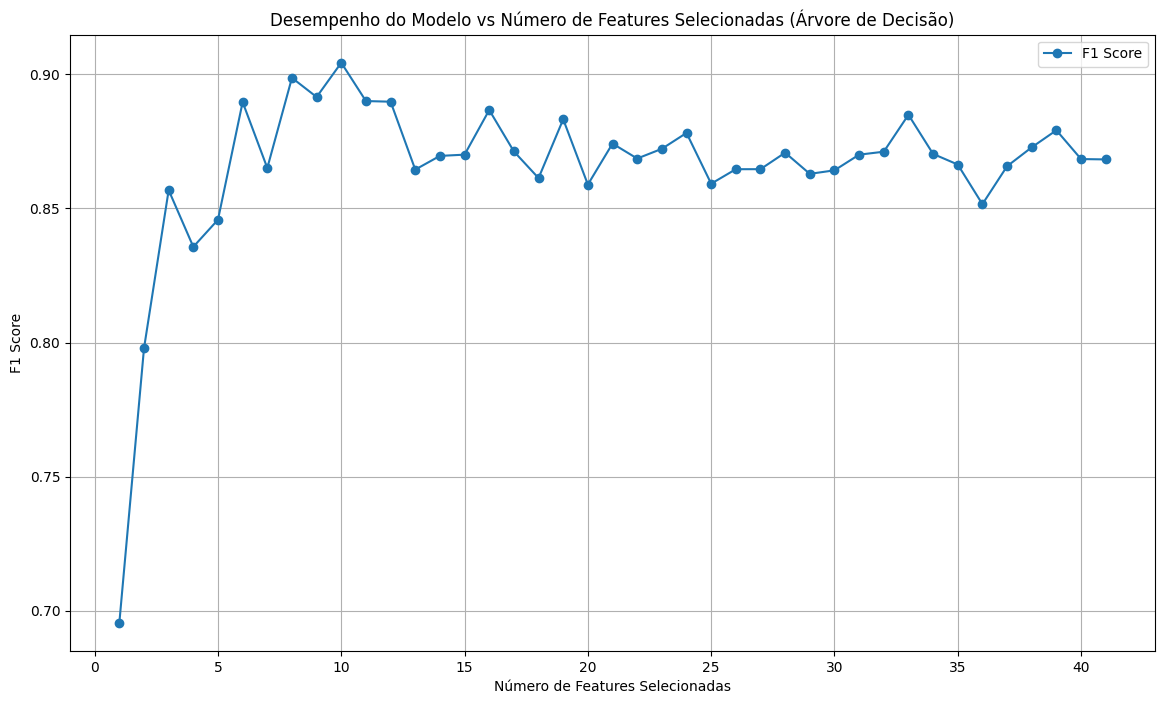

In [28]:
estimator = DecisionTreeClassifier()

# Listas para armazenar as métricas
num_features = list(range(1, X_train_c2.shape[1] + 1))
f1_scores = []

start_time_c2_ft = time.time()
# Loop através de diferentes números de features
for n in num_features:
    rfe = RFE(estimator=estimator, n_features_to_select=n)
    rfe = rfe.fit(X_train_c2, y_train_c2)
    
    # Transformar os conjuntos de treino e teste para selecionar as principais features
    X_train_c2_rfe = rfe.transform(X_train_c2)
    X_test_c2_rfe = rfe.transform(X_test_c2)
    
    # Inicializar e realizar Grid Search no modelo de Árvore de Decisão
    dt_model = DecisionTreeClassifier()
    dt_model.fit(X_train_c2_rfe, y_train_c2)
    
    
    # Fazer previsões no conjunto de teste
    y_pred_dt_test_c2 = dt_model.predict(X_test_c2_rfe)
    
    # Calcular o F1 score
    f1 = f1_score(y_test_c2, y_pred_dt_test_c2, average='macro')
    
    # Armazenar a métrica
    f1_scores.append(f1)
    print(f'n= {n} score: {f1}')
end_time_c2_ft = time.time()
# Plotar o F1 score em relação ao número de features

plt.figure(figsize=(14, 8))
plt.plot(num_features, f1_scores, label='F1 Score', marker='o')
plt.xlabel('Número de Features Selecionadas')
plt.ylabel('F1 Score')
plt.title('Desempenho do Modelo vs Número de Features Selecionadas (Árvore de Decisão)')
plt.legend()
plt.grid(True)
plt.show()

executar algoritmo com melhor feature (24)
e plotar matriz de confusão

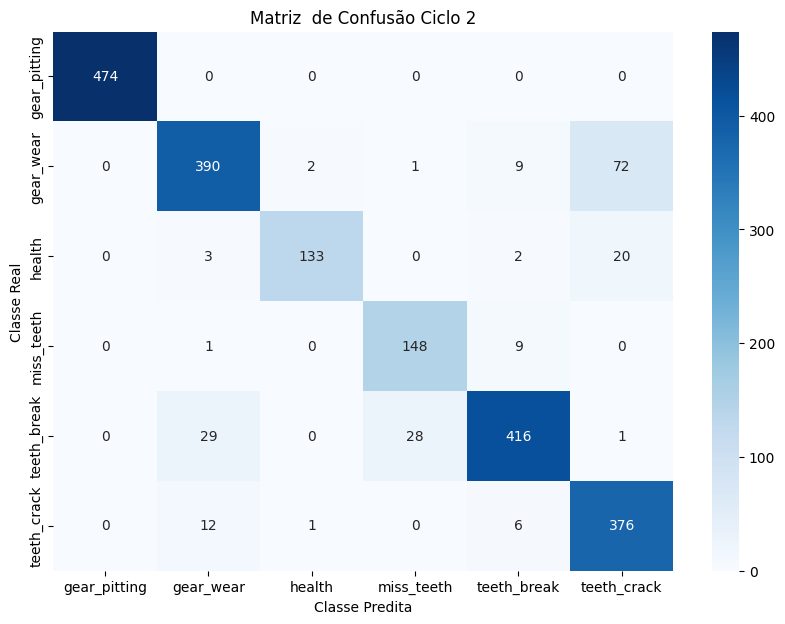

f1-score = 0.9041828527494689


In [29]:
start_time_c2_dt = time.time()
# executar algoritmo com melhor número
rfe = RFE(estimator=estimator, n_features_to_select=10)
rfe = rfe.fit(X_train_c2, y_train_c2)

# Transformar os conjuntos de treino e teste para selecionar as principais features
X_train_c2_rfe = rfe.transform(X_train_c2)
X_test_c2_rfe = rfe.transform(X_test_c2)

# Inicializar e treinar o modelo dt
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_c2_rfe, y_train_c2)    
# Fazer previsões no conjunto de teste
y_pred_dt_test_c2 = dt_model.predict(X_test_c2_rfe)

end_time_c2_dt = time.time()

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_c2, y_pred_dt_test_c2)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz  de Confusão Ciclo 2')
plt.show()

f1_dt_test_c2 = f1_score(y_test_c2, y_pred_dt_test_c2, average='macro')
print(f'f1-score = {f1_dt_test_c2}')

Resultados Ciclo 2

In [30]:
# Resultados Ciclo 2
accuracy_dt_test_c2 = accuracy_score(y_test_c2, y_pred_dt_test_c2)
recall_dt_test_c2 = recall_score(y_test_c2, y_pred_dt_test_c2, average='macro')
f1_dt_test_c2 = f1_score(y_test_c2, y_pred_dt_test_c2, average='macro')

print(f'accuracy = {accuracy_dt_test_c2}')
print(f'recall = {recall_dt_test_c2}')
print(f'f1-sciore = {f1_dt_test_c2}')

accuracy = 0.9081106422878574
recall = 0.9051336146272856
f1-sciore = 0.9041828527494689


## Ciclo 1

levantamento melhor feature (1)

In [32]:
X_train_c1

,Input Torque.rms,Input Torque.pk_pk,Input Torque.kurtosis,Input Torque.crest_factor,Input Torque.skewness,Input Torque.shape_factor,Input Torque.mean,Input Torque.std,Input Torque.min,Input Torque.max,...,gearbox_vibration_z.pk_pk,gearbox_vibration_z.kurtosis,gearbox_vibration_z.crest_factor,gearbox_vibration_z.skewness,gearbox_vibration_z.shape_factor,gearbox_vibration_z.mean,gearbox_vibration_z.std,gearbox_vibration_z.min,gearbox_vibration_z.max,Torque
0,0.345814,0.014328,0.328475,0.012063,0.324081,0.000681,0.296231,0.009428,0.301869,0.286732,...,0.149771,0.211119,0.141065,0.377673,0.331754,0.484181,0.321538,0.805905,0.130430,0
1,0.345989,0.021745,0.312702,0.013625,0.320071,0.000795,0.296154,0.012416,0.300727,0.287802,...,0.186463,0.276572,0.318899,0.334581,0.408023,0.441228,0.293573,0.732432,0.116994,0
2,0.347105,0.004511,0.293375,0.011789,0.311803,0.000691,0.295611,0.009837,0.301393,0.283331,...,0.202570,0.214269,0.233302,0.381908,0.317580,0.396278,0.325472,0.752829,0.180129,0
3,0.347813,0.021491,0.348087,0.011891,0.342203,0.000747,0.295275,0.011395,0.300962,0.287961,...,0.201218,0.274866,0.348565,0.349145,0.344502,0.638984,0.300104,0.711359,0.122700,0
4,0.348619,0.028864,0.435657,0.012255,0.454937,0.000838,0.294894,0.013812,0.300304,0.289501,...,0.262902,0.311910,0.341983,0.338132,0.491495,0.612642,0.325048,0.693863,0.239125,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,0.932783,0.043567,0.442655,0.007787,0.440993,0.000031,0.967700,0.016123,0.969540,0.962431,...,0.489463,0.419196,0.347392,0.278543,0.584078,0.240900,0.525965,0.557659,0.572424,1
2156,0.930995,0.046663,0.503780,0.007818,0.546674,0.000041,0.966839,0.017435,0.967765,0.961581,...,0.745748,0.530415,0.658763,0.287081,0.538249,0.498968,0.561833,0.269727,0.773937,1
2157,0.931063,0.048253,0.391206,0.006823,0.415706,0.000049,0.966871,0.018429,0.965688,0.959980,...,0.888014,0.870007,1.000000,0.307838,0.699644,0.699859,0.568326,0.018841,0.766411,1
2158,0.932098,0.058645,0.436180,0.008369,0.489875,0.000083,0.967363,0.022896,0.965654,0.963043,...,0.458094,0.415244,0.312507,0.374083,0.550915,0.387782,0.503161,0.563847,0.509662,1


n= 1 score: 0.9694292292685559
n= 2 score: 0.9694292292685559
n= 3 score: 0.8727880681068239
n= 4 score: 0.9114988851446426
n= 5 score: 0.9114988851446426
n= 6 score: 0.9114988851446426
n= 7 score: 0.9114988851446426
n= 8 score: 0.9114988851446426
n= 9 score: 0.9114988851446426
n= 10 score: 0.9114988851446426
n= 11 score: 0.9114988851446426
n= 12 score: 0.9114988851446426
n= 13 score: 0.9114988851446426
n= 14 score: 0.9114988851446426
n= 15 score: 0.9114988851446426
n= 16 score: 0.9070284406668847
n= 17 score: 0.9114988851446426
n= 18 score: 0.9114988851446426
n= 19 score: 0.9114988851446426
n= 20 score: 0.9114988851446426
n= 21 score: 0.9070284406668847
n= 22 score: 0.9114988851446426
n= 23 score: 0.9070284406668847
n= 24 score: 0.9114988851446426
n= 25 score: 0.9114988851446426
n= 26 score: 0.9114988851446426
n= 27 score: 0.9070284406668847
n= 28 score: 0.9070284406668847
n= 29 score: 0.9070284406668847
n= 30 score: 0.9114988851446426
n= 31 score: 0.9070284406668847
n= 32 score: 0.91

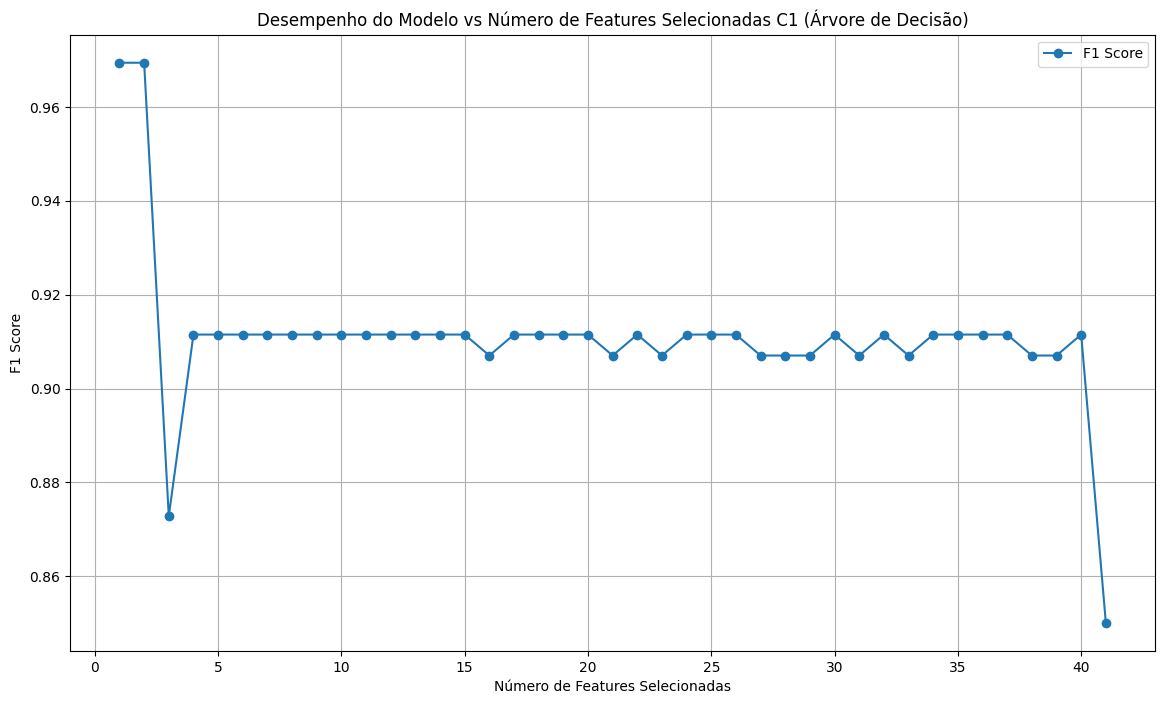

In [19]:
estimator = DecisionTreeClassifier()

# Listas para armazenar as métricas
num_features = list(range(1, X_train_c1.shape[1] + 1))
f1_scores = []

start_time_c1_ft = time.time()
# Loop através de diferentes números de features
for n in num_features:
    rfe = RFE(estimator=estimator, n_features_to_select=n)
    rfe = rfe.fit(X_train_c1, y_train_c1)
    
    # Transformar os conjuntos de treino e teste para selecionar as principais features
    X_train_c1_rfe = rfe.transform(X_train_c1)
    X_test_c1_rfe = rfe.transform(X_test_c1)
    
    # Inicializar e realizar Grid Search no modelo de Árvore de Decisão
    dt_model = DecisionTreeClassifier()
    dt_model.fit(X_train_c1_rfe, y_train_c1)
    
    # Fazer previsões no conjunto de teste
    y_pred_dt_test_c1 = dt_model.predict(X_test_c1_rfe)
    
    # Calcular o F1 score
    f1 = f1_score(y_test_c1, y_pred_dt_test_c1, average='macro')
    
    # Armazenar a métrica
    f1_scores.append(f1)
    print(f'n= {n} score: {f1}')
end_time_c1_ft = time.time()

# Plotar o F1 score em relação ao número de features
plt.figure(figsize=(14, 8))
plt.plot(num_features, f1_scores, label='F1 Score', marker='o')
plt.xlabel('Número de Features Selecionadas')
plt.ylabel('F1 Score')
plt.title('Desempenho do Modelo vs Número de Features Selecionadas C1 (Árvore de Decisão)')
plt.legend()
plt.grid(True)
plt.show()

Aplicação melhor feature
e plotar matriz de confusão

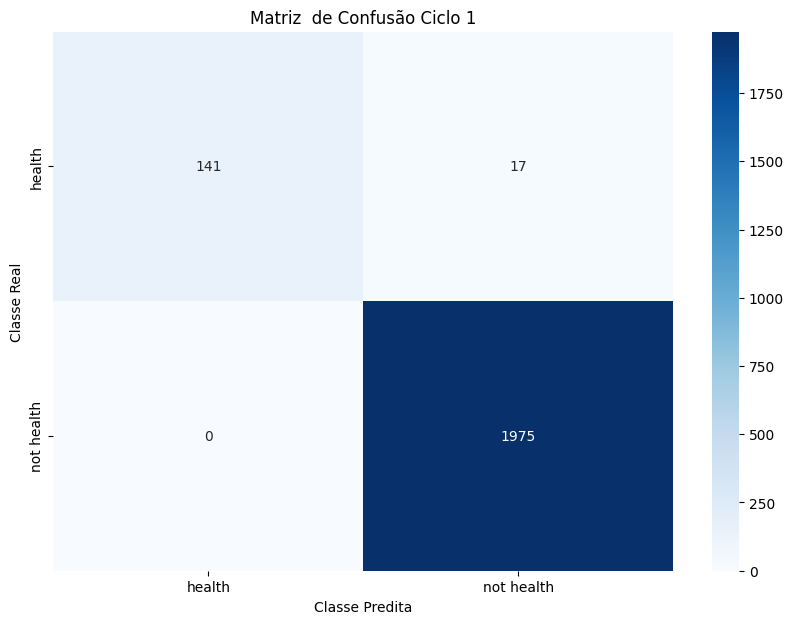

f1-sciore = 0.9694292292685559


In [31]:
start_time_c1_dt = time.time()
# executar algoritmo com melhor número
rfe = RFE(estimator=estimator, n_features_to_select=1)
rfe = rfe.fit(X_train_c1, y_train_c1)

# Transformar os conjuntos de treino e teste para selecionar as principais features
X_train_c1_rfe = rfe.transform(X_train_c1)
X_test_c1_rfe = rfe.transform(X_test_c1)

# Inicializar e treinar o modelo dt
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_c1_rfe, y_train_c1)    
# Fazer previsões no conjunto de teste
y_pred_dt_test_c1 = dt_model.predict(X_test_c1_rfe)

end_time_c1_dt = time.time()

# Plot confusion matrix
labels_c1 = ['health','not health']

conf_matrix = confusion_matrix(y_test_c1, y_pred_dt_test_c1)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels_c1, yticklabels=labels_c1)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz  de Confusão Ciclo 1')
plt.show()

f1_dt_test_c1 = f1_score(y_test_c1, y_pred_dt_test_c1, average='macro')

print(f'f1-sciore = {f1_dt_test_c1}')

In [21]:
# Resultados Ciclo 2
accuracy_dt_test_c1 = accuracy_score(y_test_c1, y_pred_dt_test_c1)
recall_dt_test_c1 = recall_score(y_test_c1, y_pred_dt_test_c1, average='macro')
f1_dt_test_c1 = f1_score(y_test_c1, y_pred_dt_test_c1, average='macro')

print(f'accuracy = {accuracy_dt_test_c1}')
print(f'recall = {recall_dt_test_c1}')
print(f'f1-sciore = {f1_dt_test_c1}')

accuracy = 0.9920300046882325
recall = 0.9462025316455696
f1-sciore = 0.9694292292685559


### Resultados DT

In [22]:
# Resultados Ciclo 1
accuracy_dt_test_c1 = accuracy_score(y_test_c1, y_pred_dt_test_c1)
recall_dt_test_c1 = recall_score(y_test_c1, y_pred_dt_test_c1, average='macro')
f1_dt_test_c1 = f1_score(y_test_c1, y_pred_dt_test_c1, average='macro')




# Create metrics table
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Recall', 'F1 Score', 'Features'],
    'Score Ciclo 1': [accuracy_dt_test_c1, recall_dt_test_c1, f1_dt_test_c1,'1'],
    'Score Ciclo 2': [accuracy_dt_test_c2, recall_dt_test_c2, f1_dt_test_c2,'9']
})

print(metrics_table)

     Metric Score Ciclo 1 Score Ciclo 2
0  Accuracy       0.99203      0.889358
1    Recall      0.946203      0.869058
2  F1 Score      0.969429      0.868225
3  Features             1             9


tempos

In [23]:
execution_time_c1_ft = end_time_c1_ft - start_time_c1_ft
execution_time_c2_ft = end_time_c2_ft - start_time_c2_ft
execution_time_c1_svm = end_time_c1_dt - start_time_c1_dt
execution_time_c2_svm = end_time_c2_dt - start_time_c2_dt

print('c1 ft')
print(execution_time_c1_ft)
print('c2 ft')
print(execution_time_c2_ft)
print('c1 svm')
print(execution_time_c1_svm)
print('c2 ft')
print(execution_time_c2_svm)

c1 ft
18.7564115524292
c2 ft
39.220410108566284
c1 svm
0.7143144607543945
c2 ft
1.1784958839416504
